делаем:
1) гпт с стопсловами
2) т5 с стопсловами
3) гпт с нер и стопсловами
4) т5 с нер и стопсловами
5) гпт без стопслов
6) т5 без стопслов
   

In [3]:
import pandas as pd
import numpy as np
import re
from transformers import pipeline, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, AutoModelForTokenClassification, AutoModelForCausalLM
from tqdm.auto import tqdm
tqdm.pandas()

In [4]:
df = pd.read_csv(r"C:\Users\dvb07\OneDrive\VKR\texts_med.csv")

In [5]:
tokenizer_gpt = AutoTokenizer.from_pretrained("IlyaGusev/rugpt3medium_sum_gazeta")
model_gpt = AutoModelForCausalLM.from_pretrained("IlyaGusev/rugpt3medium_sum_gazeta")

In [6]:
tokenizer_sacreemure = AutoTokenizer.from_pretrained("sacreemure/med_t5_summ_ru")
model_sacreemure = AutoModelForSeq2SeqLM.from_pretrained("sacreemure/med_t5_summ_ru")

In [49]:
from rouge import Rouge
from evaluate import load
import evaluate
from sacrebleu.metrics import BLEU
from bert_score import score as bert_score
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import sacrebleu
import seaborn as sns
import matplotlib.pyplot as plt

## гпт без стопслов

### тексты

In [7]:
def summarize(article):
        
    input_ids = tokenizer_gpt(article, return_tensors='pt', max_length=400, truncation=True, padding=True)["input_ids"]

    output_ids = model_gpt.generate(input_ids, max_new_tokens=300, repetition_penalty = 7.0, num_return_sequences=5, temperature = 0.7, top_k=50, early_stopping=True)[0]

    summary = tokenizer_gpt.decode(output_ids, skip_special_tokens=True)
    
    return summary

In [8]:
df['summary'] = df['text'].progress_apply(summarize)

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\dvb07\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [33]:
df.to_csv('gptnosw.csv')

In [81]:
df.sample(5)

,annotation,text,summary
7,"Известно, что для пациентов с мультифокальным ...",Введение\r\nАтеросклероз представляет собой си...,Введение\r\nАтеросклероз представляет собой си...
1,Цель исследования: клинически и морфологически...,Введение\r\nСочетание катаракты и глаукомы выз...,Введение\r\nСочетание катаракты и глаукомы выз...
4,Цель исследования: провести сравнительный анал...,Введение\r\nОжирение — это гетерогенная группа...,Введение\r\nОжирение — это гетерогенная группа...
8,Астенический синдром является одним из наиболе...,Введение\r\nАстенический синдром является одни...,Введение\r\nАстенический синдром является одни...
9,Лечение больных с функциональными расстройства...,Введение\r\nАктуальность проблемы функциональн...,Введение\r\nАктуальность проблемы функциональн...


### метрики

In [50]:
data = pd.read_csv(r"C:\Users\dvb07\OneDrive\projects\gptnosw.csv")

In [55]:
import nltk

In [56]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dvb07\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
rouge = Rouge()
smoothing = SmoothingFunction()

total_rouge_1 = 0.0
total_rouge_2 = 0.0
total_rouge_l = 0.0
total_bert_score = 0.0
total_bleu_score = 0.0
total_meteor_score = 0.0
num_pairs = len(data)

for index, row in data.iterrows():
    generated_summary = row['summary']
    reference_summary = row['annotation']

    _, _, bert_f1 = bert_score([generated_summary], [reference_summary], lang="ru")
    total_bert_score += bert_f1.item()
    
    # Calculate BLEU score using SacreBLEU
    bleu = sacrebleu.corpus_bleu([generated_summary], [reference_summary])
    total_bleu_score += bleu.score
    
    scores = rouge.get_scores(generated_summary, reference_summary)
    total_rouge_1 += scores[0]['rouge-1']['f']
    total_rouge_2 += scores[0]['rouge-2']['f']
    total_rouge_l += scores[0]['rouge-l']['f']
    
    # Tokenize generated and reference summaries
    generated_tokens = nltk.word_tokenize(generated_summary)
    reference_tokens = nltk.word_tokenize(reference_summary)
    
    meteor = meteor_score([reference_tokens], generated_tokens)
    total_meteor_score += meteor
    

avg_bert_score_gpt = total_bert_score / num_pairs
avg_bleu_score_gpt = total_bleu_score / num_pairs
avg_rouge_1_gpt = total_rouge_1 / num_pairs
avg_rouge_2_gpt = total_rouge_2 / num_pairs
avg_rouge_l_gpt = total_rouge_l / num_pairs
avg_meteor_score_gpt = total_meteor_score / num_pairs


print(f"Average BERTScore: {avg_bert_score_gpt}")
print(f"Average BLEU Score: {avg_bleu_score_gpt}")
print(f"Average ROUGE-1: {avg_rouge_1_gpt}")
print(f"Average ROUGE-2: {avg_rouge_2_gpt}")
print(f"Average ROUGE-L: {avg_rouge_l_gpt}")
print(f"Average METEOR Score: {avg_meteor_score_gpt}")


Average BERTScore: 0.715637332201004
Average BLEU Score: 0.02982698819626281
Average ROUGE-1: 0.19419361796034423
Average ROUGE-2: 0.07683851427040019
Average ROUGE-L: 0.1844829401359945
Average METEOR Score: 0.24033794153548063


## гпт с стопсловами

### генерация

In [9]:
df1 = pd.read_csv(r"C:\Users\dvb07\OneDrive\VKR\texts_med.csv")

In [10]:
def preprocess_text(article):
    stop_words = ["введение", "выводы", "данные", "заключение"]
    reference_pattern = r'\[\d+\]'

    for word in stop_words:
        article = article.replace(word, "")

    article = re.sub(reference_pattern, '', article)

    return article

def summarize(article):
    input_ids = tokenizer_gpt(article, return_tensors='pt', max_length=400, truncation=True, padding=True)["input_ids"]

    output_ids = model_gpt.generate(input_ids, max_new_tokens=300, repetition_penalty=7.0, num_return_sequences=5, temperature=0.7, top_k=50, early_stopping=True)[0]

    summary = tokenizer_gpt.decode(output_ids, skip_special_tokens=True)
    
    return summary


In [11]:
df1['preprocessed_text'] = df1['text'].apply(preprocess_text)

df1['summary'] = df1['preprocessed_text'].progress_apply(summarize)


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\dvb07\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [32]:
df1.to_csv('gptstopwords.csv')

### metrics

In [63]:
data = pd.read_csv(r"C:\Users\dvb07\OneDrive\projects\gptstopwords.csv")

rouge = Rouge()

total_rouge_1 = 0.0
total_rouge_2 = 0.0
total_rouge_l = 0.0
total_bert_score = 0.0
total_bleu_score = 0.0
total_meteor_score = 0.0
num_pairs = len(data)

for index, row in data.iterrows():
    generated_summary = row['summary']
    reference_summary = row['annotation']

    _, _, bert_f1 = bert_score([generated_summary], [reference_summary], lang="ru")
    total_bert_score += bert_f1.item()
    
    bleu = sacrebleu.corpus_bleu([generated_summary], [reference_summary])
    total_bleu_score += bleu.score
    
    scores = rouge.get_scores(generated_summary, reference_summary)
    total_rouge_1 += scores[0]['rouge-1']['f']
    total_rouge_2 += scores[0]['rouge-2']['f']
    total_rouge_l += scores[0]['rouge-l']['f']
    
    generated_tokens = nltk.word_tokenize(generated_summary)
    reference_tokens = nltk.word_tokenize(reference_summary)
    
    meteor = meteor_score([reference_tokens], generated_tokens)
    total_meteor_score += meteor
    

avg_bert_score_gptsw = total_bert_score / num_pairs
avg_bleu_score_gptsw = total_bleu_score / num_pairs
avg_rouge_1_gptsw = total_rouge_1 / num_pairs
avg_rouge_2_gptsw = total_rouge_2 / num_pairs
avg_rouge_l_gptsw = total_rouge_l / num_pairs
avg_meteor_score_gptsw = total_meteor_score / num_pairs


print(f"Average BERTScore: {avg_bert_score_gptsw}")
print(f"Average BLEU Score: {avg_bleu_score_gptsw}")
print(f"Average ROUGE-1: {avg_rouge_1_gptsw}")
print(f"Average ROUGE-2: {avg_rouge_2_gptsw}")
print(f"Average ROUGE-L: {avg_rouge_l_gptsw}")
print(f"Average METEOR Score: {avg_meteor_score_gptsw}")


Average BERTScore: 0.7168043434619904
Average BLEU Score: 0.033149525413434265
Average ROUGE-1: 0.20246236377047128
Average ROUGE-2: 0.08386632593653817
Average ROUGE-L: 0.19235825418803132
Average METEOR Score: 0.24676002232004768


------------------

In [12]:
pipe = pipeline("token-classification", model="denis-gordeev/rured2-ner-microsoft-mdeberta-v3-base")

---------------------------------------

## гпт с нер

### texts

In [34]:
df2 = pd.read_csv(r"C:\Users\dvb07\OneDrive\VKR\texts_med.csv")

In [35]:
def summarize(article):
    
    ner_results = pipe(article)
    entities = [entity['word'] for entity in ner_results if entity['entity'] != 'O']
    entity_string = " ".join(entities)

    max_length = 2048 - len(entity_string)

    input_ids = tokenizer_gpt(article, return_tensors='pt', max_length=max_length, truncation=True, padding=True)["input_ids"]

    output_ids = model_gpt.generate(input_ids, max_new_tokens=300, repetition_penalty = 7.0, num_return_sequences=5, temperature = 0.7, top_k=50, early_stopping=True)[0]

    summary = tokenizer_gpt.decode(output_ids, skip_special_tokens=True)
    
    return summary

In [36]:
df2['summary'] = df2['text'].progress_apply(summarize)

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\dvb07\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [37]:
df2.to_csv('gptner.csv')

### metrics

In [65]:
data = pd.read_csv(r"C:\Users\dvb07\OneDrive\projects\gptner.csv")

rouge = Rouge()

total_rouge_1 = 0.0
total_rouge_2 = 0.0
total_rouge_l = 0.0
total_bert_score = 0.0
total_bleu_score = 0.0
total_meteor_score = 0.0
num_pairs = len(data)

for index, row in data.iterrows():
    generated_summary = row['summary']
    reference_summary = row['annotation']

    _, _, bert_f1 = bert_score([generated_summary], [reference_summary], lang="ru")
    total_bert_score += bert_f1.item()
    
    bleu = sacrebleu.corpus_bleu([generated_summary], [reference_summary])
    total_bleu_score += bleu.score
    
    scores = rouge.get_scores(generated_summary, reference_summary)
    total_rouge_1 += scores[0]['rouge-1']['f']
    total_rouge_2 += scores[0]['rouge-2']['f']
    total_rouge_l += scores[0]['rouge-l']['f']
    
    generated_tokens = nltk.word_tokenize(generated_summary)
    reference_tokens = nltk.word_tokenize(reference_summary)
    
    meteor = meteor_score([reference_tokens], generated_tokens)
    total_meteor_score += meteor
    

avg_bert_score_gptner = total_bert_score / num_pairs
avg_bleu_score_gptner = total_bleu_score / num_pairs
avg_rouge_1_gptner = total_rouge_1 / num_pairs
avg_rouge_2_gptner = total_rouge_2 / num_pairs
avg_rouge_l_gptner = total_rouge_l / num_pairs
avg_meteor_score_gptner = total_meteor_score / num_pairs


print(f"Average BERTScore: {avg_bert_score_gptner}")
print(f"Average BLEU Score: {avg_bleu_score_gptner}")
print(f"Average ROUGE-1: {avg_rouge_1_gptner}")
print(f"Average ROUGE-2: {avg_rouge_2_gptner}")
print(f"Average ROUGE-L: {avg_rouge_l_gptner}")
print(f"Average METEOR Score: {avg_meteor_score_gptner}")


Average BERTScore: 0.7155093729496003
Average BLEU Score: 0.015052887837225332
Average ROUGE-1: 0.22593926896366953
Average ROUGE-2: 0.11340349973459322
Average ROUGE-L: 0.21709984611338626
Average METEOR Score: 0.319021499731305


## гпт с нер и стопсловами

### text

In [38]:
df6 = pd.read_csv(r"C:\Users\dvb07\OneDrive\VKR\texts_med.csv")

In [40]:
def preprocess_text(article):
    stop_words = ["введение", "выводы", "данные", "заключение"]
    reference_pattern = r'\[\d+\]'

    for word in stop_words:
        article = article.replace(word, "")

    article = re.sub(reference_pattern, '', article)

    return article
    
def summarize(article):
    
    ner_results = pipe(article)
    entities = [entity['word'] for entity in ner_results if entity['entity'] != 'O']
    entity_string = " ".join(entities)

    max_length = 2048 - len(entity_string)

    input_ids = tokenizer_gpt(article, return_tensors='pt', max_length=max_length, truncation=True, padding=True)["input_ids"]

    output_ids = model_gpt.generate(input_ids, max_new_tokens=300, repetition_penalty = 7.0, num_return_sequences=5, temperature = 0.7, top_k=50, early_stopping=True)[0]

    summary = tokenizer_gpt.decode(output_ids, skip_special_tokens=True)
    
    return summary

In [41]:
df6['preprocessed_text'] = df6['text'].apply(preprocess_text)

In [42]:
df6['summary'] = df6['preprocessed_text'].progress_apply(summarize)

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\dvb07\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [43]:
df6.to_csv('gptnersw.csv')

### metrics

In [68]:
data = pd.read_csv(r"C:\Users\dvb07\OneDrive\projects\gptnersw.csv")

rouge = Rouge()

total_rouge_1 = 0.0
total_rouge_2 = 0.0
total_rouge_l = 0.0
total_bert_score = 0.0
total_bleu_score = 0.0
total_meteor_score = 0.0
num_pairs = len(data)

for index, row in data.iterrows():
    generated_summary = row['summary']
    reference_summary = row['annotation']

    _, _, bert_f1 = bert_score([generated_summary], [reference_summary], lang="ru")
    total_bert_score += bert_f1.item()
    
    bleu = sacrebleu.corpus_bleu([generated_summary], [reference_summary])
    total_bleu_score += bleu.score
    
    scores = rouge.get_scores(generated_summary, reference_summary)
    total_rouge_1 += scores[0]['rouge-1']['f']
    total_rouge_2 += scores[0]['rouge-2']['f']
    total_rouge_l += scores[0]['rouge-l']['f']
    
    generated_tokens = nltk.word_tokenize(generated_summary)
    reference_tokens = nltk.word_tokenize(reference_summary)
    
    meteor = meteor_score([reference_tokens], generated_tokens)
    total_meteor_score += meteor
    

avg_bert_score_gptnersw = total_bert_score / num_pairs
avg_bleu_score_gptnersw = total_bleu_score / num_pairs
avg_rouge_1_gptnersw = total_rouge_1 / num_pairs
avg_rouge_2_gptnersw = total_rouge_2 / num_pairs
avg_rouge_l_gptnersw = total_rouge_l / num_pairs
avg_meteor_score_gptnersw = total_meteor_score / num_pairs


print(f"Average BERTScore: {avg_bert_score_gptnersw}")
print(f"Average BLEU Score: {avg_bleu_score_gptnersw}")
print(f"Average ROUGE-1: {avg_rouge_1_gptnersw}")
print(f"Average ROUGE-2: {avg_rouge_2_gptnersw}")
print(f"Average ROUGE-L: {avg_rouge_l_gptnersw}")
print(f"Average METEOR Score: {avg_meteor_score_gptnersw}")


Average BERTScore: 0.7164736986160278
Average BLEU Score: 0.015464787515106873
Average ROUGE-1: 0.22867148242030835
Average ROUGE-2: 0.11539199994547708
Average ROUGE-L: 0.21862052368386847
Average METEOR Score: 0.3212456945319137


## т5 без стопслов

### text

In [13]:
df3 = pd.read_csv(r"C:\Users\dvb07\OneDrive\VKR\texts_med.csv")

In [14]:
def summarize(article):
        
    input_ids = tokenizer_sacreemure(article, return_tensors='pt', max_length=2048, truncation=True)["input_ids"]

    output_ids = model_sacreemure.generate(input_ids, min_length=800, max_length=1000, repetition_penalty = 2.0, num_return_sequences=1, top_k=50, early_stopping=True)[0]

    summary = tokenizer_sacreemure.decode(output_ids, skip_special_tokens=True)
    
    return summary

In [15]:
df3['summary'] = df3['text'].progress_apply(summarize)

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
df3.to_csv('t5nosw.csv')

### metrics

In [70]:
data = pd.read_csv(r"C:\Users\dvb07\OneDrive\projects\t5nosw.csv")

rouge = Rouge()

total_rouge_1 = 0.0
total_rouge_2 = 0.0
total_rouge_l = 0.0
total_bert_score = 0.0
total_bleu_score = 0.0
total_meteor_score = 0.0
num_pairs = len(data)

for index, row in data.iterrows():
    generated_summary = row['summary']
    reference_summary = row['annotation']

    _, _, bert_f1 = bert_score([generated_summary], [reference_summary], lang="ru")
    total_bert_score += bert_f1.item()
    
    bleu = sacrebleu.corpus_bleu([generated_summary], [reference_summary])
    total_bleu_score += bleu.score
    
    scores = rouge.get_scores(generated_summary, reference_summary)
    total_rouge_1 += scores[0]['rouge-1']['f']
    total_rouge_2 += scores[0]['rouge-2']['f']
    total_rouge_l += scores[0]['rouge-l']['f']
    
    generated_tokens = nltk.word_tokenize(generated_summary)
    reference_tokens = nltk.word_tokenize(reference_summary)
    
    meteor = meteor_score([reference_tokens], generated_tokens)
    total_meteor_score += meteor
    

avg_bert_score_t5 = total_bert_score / num_pairs
avg_bleu_score_t5 = total_bleu_score / num_pairs
avg_rouge_1_t5 = total_rouge_1 / num_pairs
avg_rouge_2_t5 = total_rouge_2 / num_pairs
avg_rouge_l_t5 = total_rouge_l / num_pairs
avg_meteor_score_t5 = total_meteor_score / num_pairs


print(f"Average BERTScore: {avg_bert_score_t5}")
print(f"Average BLEU Score: {avg_bleu_score_t5}")
print(f"Average ROUGE-1: {avg_rouge_1_t5}")
print(f"Average ROUGE-2: {avg_rouge_2_t5}")
print(f"Average ROUGE-L: {avg_rouge_l_t5}")
print(f"Average METEOR Score: {avg_meteor_score_t5}")


Average BERTScore: 0.7060060262680053
Average BLEU Score: 0.009889653694079681
Average ROUGE-1: 0.20029529701265494
Average ROUGE-2: 0.07030956866604282
Average ROUGE-L: 0.18842385992068036
Average METEOR Score: 0.217518327812396


## т5 с стопсловами

### texts

In [16]:
df4 = pd.read_csv(r"C:\Users\dvb07\OneDrive\VKR\texts_med.csv")

In [17]:
def preprocess_text(article):
    stop_words = ["введение", "выводы", "данные", "заключение"]
    reference_pattern = r'\[\d+\]'

    for word in stop_words:
        article = article.replace(word, "")

    article = re.sub(reference_pattern, '', article)

    return article

def summarize(article):
    input_ids = tokenizer_sacreemure(article, return_tensors='pt', max_length=2048, truncation=True)["input_ids"]

    output_ids = model_sacreemure.generate(input_ids, min_length=800, max_length=1000, repetition_penalty = 2.0, num_return_sequences=1, top_k=50, early_stopping=True)[0]

    summary = tokenizer_sacreemure.decode(output_ids, skip_special_tokens=True)
    
    return summary


In [18]:
df4['preprocessed_text'] = df4['text'].apply(preprocess_text)

df4['summary'] = df4['preprocessed_text'].progress_apply(summarize)

  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
df4.to_csv('t5stopwords.csv')

### metrics

In [71]:
data = pd.read_csv(r"C:\Users\dvb07\OneDrive\projects\t5stopwords.csv")

rouge = Rouge()

total_rouge_1 = 0.0
total_rouge_2 = 0.0
total_rouge_l = 0.0
total_bert_score = 0.0
total_bleu_score = 0.0
total_meteor_score = 0.0
num_pairs = len(data)

for index, row in data.iterrows():
    generated_summary = row['summary']
    reference_summary = row['annotation']

    _, _, bert_f1 = bert_score([generated_summary], [reference_summary], lang="ru")
    total_bert_score += bert_f1.item()
    
    bleu = sacrebleu.corpus_bleu([generated_summary], [reference_summary])
    total_bleu_score += bleu.score
    
    scores = rouge.get_scores(generated_summary, reference_summary)
    total_rouge_1 += scores[0]['rouge-1']['f']
    total_rouge_2 += scores[0]['rouge-2']['f']
    total_rouge_l += scores[0]['rouge-l']['f']
    
    generated_tokens = nltk.word_tokenize(generated_summary)
    reference_tokens = nltk.word_tokenize(reference_summary)
    
    meteor = meteor_score([reference_tokens], generated_tokens)
    total_meteor_score += meteor
    

avg_bert_score_t5sw = total_bert_score / num_pairs
avg_bleu_score_t5sw = total_bleu_score / num_pairs
avg_rouge_1_t5sw = total_rouge_1 / num_pairs
avg_rouge_2_t5sw = total_rouge_2 / num_pairs
avg_rouge_l_t5sw = total_rouge_l / num_pairs
avg_meteor_score_t5sw = total_meteor_score / num_pairs


print(f"Average BERTScore: {avg_bert_score_t5sw}")
print(f"Average BLEU Score: {avg_bleu_score_t5sw}")
print(f"Average ROUGE-1: {avg_rouge_1_t5sw}")
print(f"Average ROUGE-2: {avg_rouge_2_t5sw}")
print(f"Average ROUGE-L: {avg_rouge_l_t5sw}")
print(f"Average METEOR Score: {avg_meteor_score_t5sw}")


Average BERTScore: 0.7220237076282501
Average BLEU Score: 0.017615891563731816
Average ROUGE-1: 0.20292334588147823
Average ROUGE-2: 0.06253511199006072
Average ROUGE-L: 0.191636253109569
Average METEOR Score: 0.22480401974001984


## т5 с нер

### texts

In [24]:
df5 = pd.read_csv(r"C:\Users\dvb07\OneDrive\VKR\texts_med.csv")

In [27]:
def process_row(article):
    
    ner_results = pipe(article)
    entities = [entity['word'] for entity in ner_results if entity['entity'] != 'O']
    entity_string = " ".join(entities)

    max_length = 2048 - len(entity_string)

    input_ids = tokenizer_sacreemure(article, return_tensors='pt', max_length=max_length, truncation=True)["input_ids"]

    output_ids = model_sacreemure.generate(input_ids, min_length=800, max_length=1000, repetition_penalty = 2.0, num_return_sequences=1, top_k=50, early_stopping=True)[0]

    summary = tokenizer_sacreemure.decode(output_ids, skip_special_tokens=True)
    
    return summary

In [28]:
df5['summary'] = df5['text'].progress_apply(process_row)

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [29]:
df5.to_csv('t5ner.csv')

### metrics

In [73]:
data = pd.read_csv(r"C:\Users\dvb07\OneDrive\projects\t5ner.csv")

rouge = Rouge()

total_rouge_1 = 0.0
total_rouge_2 = 0.0
total_rouge_l = 0.0
total_bert_score = 0.0
total_bleu_score = 0.0
total_meteor_score = 0.0
num_pairs = len(data)

for index, row in data.iterrows():
    generated_summary = row['summary']
    reference_summary = row['annotation']

    _, _, bert_f1 = bert_score([generated_summary], [reference_summary], lang="ru")
    total_bert_score += bert_f1.item()
    
    bleu = sacrebleu.corpus_bleu([generated_summary], [reference_summary])
    total_bleu_score += bleu.score
    
    scores = rouge.get_scores(generated_summary, reference_summary)
    total_rouge_1 += scores[0]['rouge-1']['f']
    total_rouge_2 += scores[0]['rouge-2']['f']
    total_rouge_l += scores[0]['rouge-l']['f']
    
    generated_tokens = nltk.word_tokenize(generated_summary)
    reference_tokens = nltk.word_tokenize(reference_summary)
    
    meteor = meteor_score([reference_tokens], generated_tokens)
    total_meteor_score += meteor
    

avg_bert_score_t5ner = total_bert_score / num_pairs
avg_bleu_score_t5ner = total_bleu_score / num_pairs
avg_rouge_1_t5ner = total_rouge_1 / num_pairs
avg_rouge_2_t5ner = total_rouge_2 / num_pairs
avg_rouge_l_t5ner = total_rouge_l / num_pairs
avg_meteor_score_t5ner = total_meteor_score / num_pairs


print(f"Average BERTScore: {avg_bert_score_t5ner}")
print(f"Average BLEU Score: {avg_bleu_score_t5ner}")
print(f"Average ROUGE-1: {avg_rouge_1_t5ner}")
print(f"Average ROUGE-2: {avg_rouge_2_t5ner}")
print(f"Average ROUGE-L: {avg_rouge_l_t5ner}")
print(f"Average METEOR Score: {avg_meteor_score_t5ner}")


Average BERTScore: 0.6895514249801635
Average BLEU Score: 0.0
Average ROUGE-1: 0.19499545519319392
Average ROUGE-2: 0.07349957703658046
Average ROUGE-L: 0.1864979904223519
Average METEOR Score: 0.2166501187776962


## т5 нер и стопслова

### texts

In [39]:
df7 = pd.read_csv(r"C:\Users\dvb07\OneDrive\VKR\texts_med.csv")

In [44]:
def preprocess_text(article):
    stop_words = ["введение", "выводы", "данные", "заключение"]
    reference_pattern = r'\[\d+\]'

    for word in stop_words:
        article = article.replace(word, "")

    article = re.sub(reference_pattern, '', article)

    return article
    
def summarize(article):
    
    ner_results = pipe(article)
    entities = [entity['word'] for entity in ner_results if entity['entity'] != 'O']
    entity_string = " ".join(entities)

    max_length = 2048 - len(entity_string)

    input_ids = tokenizer_sacreemure(article, return_tensors='pt', max_length=max_length, truncation=True)["input_ids"]

    output_ids = model_sacreemure.generate(input_ids, min_length=800, max_length=1000, repetition_penalty = 2.0, num_return_sequences=1, top_k=50, early_stopping=True)[0]

    summary = tokenizer_sacreemure.decode(output_ids, skip_special_tokens=True)
    
    return summary

In [45]:
df7['preprocessed_text'] = df7['text'].apply(preprocess_text)

In [46]:
df7['summary'] = df7['preprocessed_text'].progress_apply(summarize)

  0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
df7.to_csv('t5nersw.csv')

### metrics

In [74]:
data = pd.read_csv(r"C:\Users\dvb07\OneDrive\projects\t5nersw.csv")

rouge = Rouge()

total_rouge_1 = 0.0
total_rouge_2 = 0.0
total_rouge_l = 0.0
total_bert_score = 0.0
total_bleu_score = 0.0
total_meteor_score = 0.0
num_pairs = len(data)

for index, row in data.iterrows():
    generated_summary = row['summary']
    reference_summary = row['annotation']

    _, _, bert_f1 = bert_score([generated_summary], [reference_summary], lang="ru")
    total_bert_score += bert_f1.item()
    
    bleu = sacrebleu.corpus_bleu([generated_summary], [reference_summary])
    total_bleu_score += bleu.score
    
    scores = rouge.get_scores(generated_summary, reference_summary)
    total_rouge_1 += scores[0]['rouge-1']['f']
    total_rouge_2 += scores[0]['rouge-2']['f']
    total_rouge_l += scores[0]['rouge-l']['f']
    
    generated_tokens = nltk.word_tokenize(generated_summary)
    reference_tokens = nltk.word_tokenize(reference_summary)
    
    meteor = meteor_score([reference_tokens], generated_tokens)
    total_meteor_score += meteor
    

avg_bert_score_t5nersw = total_bert_score / num_pairs
avg_bleu_score_t5nersw = total_bleu_score / num_pairs
avg_rouge_1_t5nersw = total_rouge_1 / num_pairs
avg_rouge_2_t5nersw = total_rouge_2 / num_pairs
avg_rouge_l_t5nersw = total_rouge_l / num_pairs
avg_meteor_score_t5nersw = total_meteor_score / num_pairs


print(f"Average BERTScore: {avg_bert_score_t5nersw}")
print(f"Average BLEU Score: {avg_bleu_score_t5nersw}")
print(f"Average ROUGE-1: {avg_rouge_1_t5nersw}")
print(f"Average ROUGE-2: {avg_rouge_2_t5nersw}")
print(f"Average ROUGE-L: {avg_rouge_l_t5nersw}")
print(f"Average METEOR Score: {avg_meteor_score_t5nersw}")


Average BERTScore: 0.6828571200370789
Average BLEU Score: 0.0
Average ROUGE-1: 0.18828068762508038
Average ROUGE-2: 0.05849259067912451
Average ROUGE-L: 0.18033223299668635
Average METEOR Score: 0.18972420766761866


## Comparison

### gpt

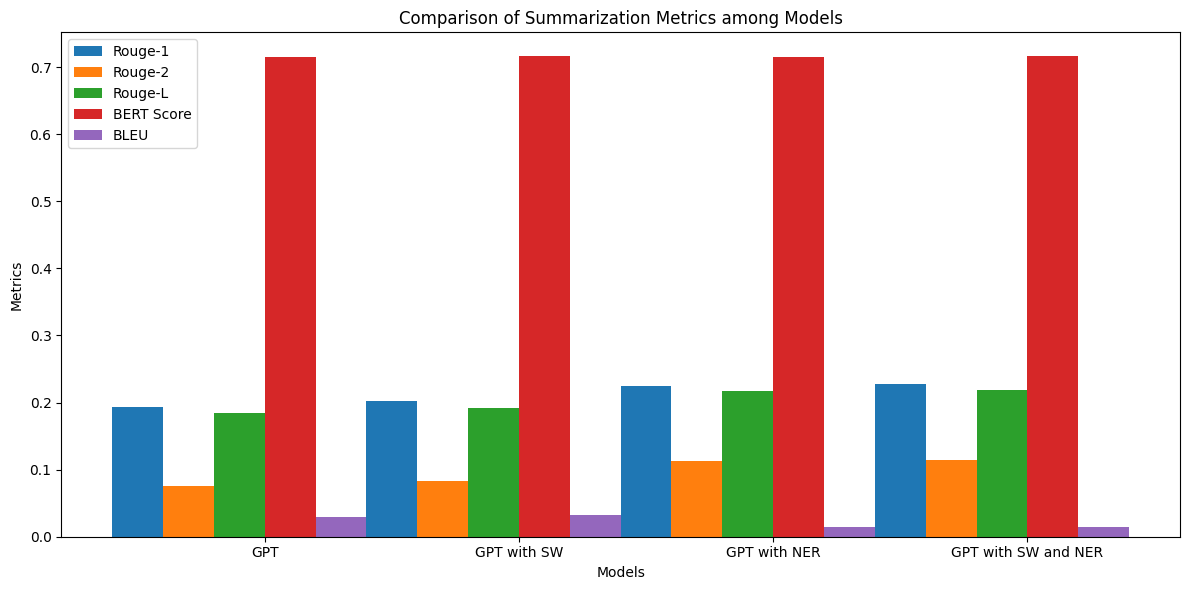

In [84]:
models = ['GPT', 'GPT with SW', 'GPT with NER', 'GPT with SW and NER']
metrics = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'BERT Score', 'BLEU']
values = np.array([
    [0.194, 0.076, 0.184, 0.715, 0.029],
    [0.202, 0.083, 0.192, 0.716, 0.033],
    [0.225, 0.113, 0.217, 0.715, 0.015],
    [0.228, 0.115, 0.218, 0.716, 0.015]
])

# Plotting
num_models = len(models)
num_metrics = len(metrics)
bar_width = 0.2
index = np.arange(num_models)

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(num_metrics):
    ax.bar(index + i * bar_width, values[:, i], bar_width, label=metrics[i])

ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Comparison of Summarization Metrics among Models')
ax.set_xticks(index + bar_width * num_metrics / 2)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

In [85]:
plt.savefig('gpt_summ_metrics_comp.png', dpi=300)

<Figure size 640x480 with 0 Axes>

### t5

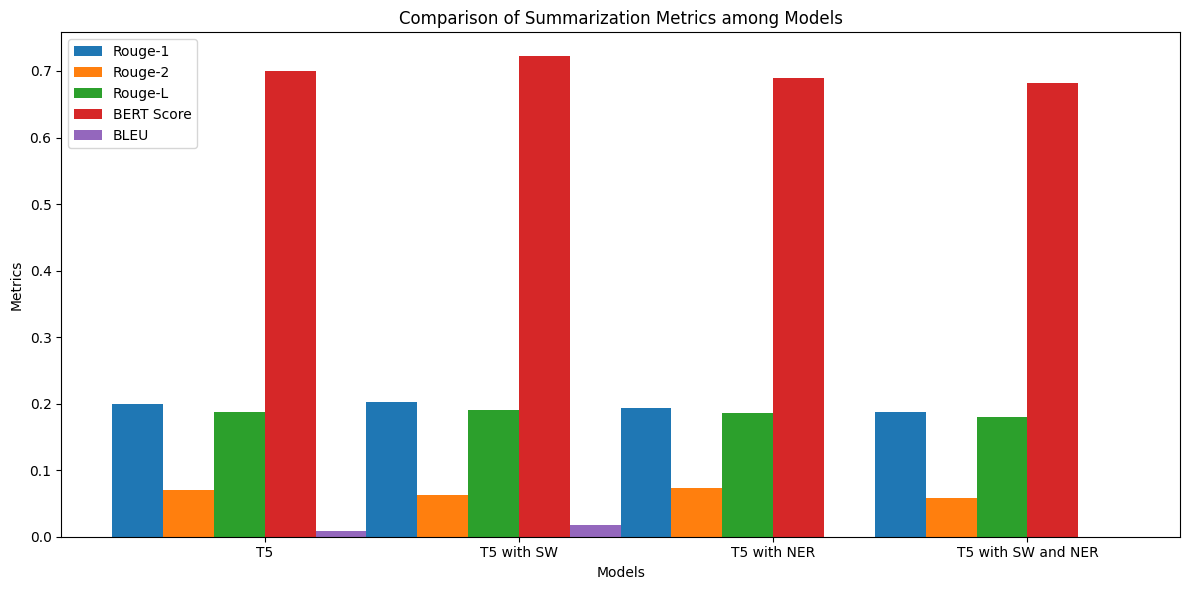

In [82]:
models = ['T5', 'T5 with SW', 'T5 with NER', 'T5 with SW and NER']
metrics = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'BERT Score', 'BLEU']
values = np.array([
    [0.2, 0.07, 0.188, 0.7, 0.009],
    [0.202, 0.0625, 0.191, 0.722, 0.017],
    [0.194, 0.073, 0.186, 0.689, 0.0],
    [0.188, 0.058, 0.18, 0.682, 0.0]
])

num_models = len(models)
num_metrics = len(metrics)
bar_width = 0.2
index = np.arange(num_models)

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(num_metrics):
    ax.bar(index + i * bar_width, values[:, i], bar_width, label=metrics[i])

ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Comparison of Summarization Metrics among Models')
ax.set_xticks(index + bar_width * num_metrics / 2)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

In [83]:
plt.savefig('t5_summ_metrics_comp.png', dpi=300)

<Figure size 640x480 with 0 Axes>